In [1]:
import numpy as np
import pandas as pd
import pandasql as pdsql
from datetime import datetime
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.ensemble import *
from sklearn.metrics import accuracy_score, roc_curve, auc



pysql = lambda q: pdsql.sqldf(q, globals())

features = pd.read_csv('data/amico-features-export.csv.gz', compression='gzip')
features.sort_values(by=['dump_id'],inplace=True)
features.set_index(features['dump_id'],inplace=True)

metadata = pd.read_csv('data/amico-export.csv.gz', compression='gzip')
metadata.sort_values(by=['dump_id'],inplace=True)
metadata['date'] = pd.to_datetime(metadata['date'])
metadata = metadata[metadata['dump_id'].isin(features['dump_id'])]
metadata.set_index(metadata['dump_id'],inplace=True)

print ("Number of rows in metadata =", len(metadata))
print ("Number of rows in features =", len(features))

Number of rows in metadata = 121545
Number of rows in features = 121545


In [2]:
data = features.join(metadata[['dump_id','date','md5','host','type','max_tavs','max_avs','score']], how='inner', rsuffix='_d')
data.sort_values(by=['dump_id'],inplace=True)

print ("Number of rows in data after join =", len(data))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 'dump_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  


Number of rows in data after join = 121545


In [3]:
dataset = data.copy()
dataset = dataset.loc[~dataset['max_avs'].isnull()]
print ("Number of remaining rows =", len(dataset))
# Removing those values where RF is not giving score
dataset = dataset.loc[~dataset['score'].isnull()]
print ("Number of remaining rows =", len(dataset))

Number of remaining rows = 112472
Number of remaining rows = 112361


In [4]:
def label_downloads(avs_count, avs_count1, threshold):
    avs_count = list(avs_count)
    avs_count1 = list(avs_count1)
    labels = ['benign']*len(avs_count)
    for i in range(len(avs_count)):
        if avs_count[i] >= threshold : 
            labels[i] = 'malware'
        elif ((avs_count1[i] > 0) and (avs_count[i] < 2)) :
            labels[i] = 'unknown'
    return labels

threshold = 2
avs_count = dataset['max_tavs']
avs_count1 = dataset['max_avs']
dataset['avs5'] = label_downloads(avs_count, avs_count1, threshold)

dataset = dataset.loc[dataset['avs5'] != 'unknown']
print ("Number of remaining rows =", len(dataset))

print ("Dataset: instances =",dataset.shape[0], "  features =",dataset.shape[1])


Number of remaining rows = 94626
Dataset: instances = 94626   features = 80


In [5]:
labels_count = Counter(list(dataset['avs5']))
print ("Labels count:", labels_count)

type_count = Counter(list(dataset['type']))
print ("Type count:", type_count)

Labels count: Counter({'benign': 90077, 'malware': 4549})
Type count: Counter({'EXE': 36779, 'JAR': 31613, 'APK': 16069, 'DMG': 10165})


In [6]:
# One-hot-encoding
cfs = ['extension_class','type']
for fn in cfs:
    ohe_feat = pd.get_dummies(dataset[fn], prefix=fn)
    dataset = dataset.drop([fn], axis=1)
    dataset = pd.concat((dataset, ohe_feat), axis=1)

print ("Dataset: instances =",dataset.shape[0], "  features =",dataset.shape[1])

Dataset: instances = 94626   features = 88


In [7]:
trainining_end_date = '2017-04-01'

training_data = dataset[dataset['date']<trainining_end_date]
test_data = dataset[dataset['date']>=trainining_end_date]

print ("Number of test data rows =", len(training_data))
print ("Number of training data rows =", len(test_data))

labels_count = Counter(list(training_data['avs5']))
print ("Training labels count:", labels_count)

labels_count = Counter(list(test_data['avs5']))
print ("Test labels count:", labels_count)

Number of test data rows = 36379
Number of training data rows = 58247
Training labels count: Counter({'benign': 34373, 'malware': 2006})
Test labels count: Counter({'benign': 55704, 'malware': 2543})


In [ ]:
train = training_data.copy()
test = test_data.copy()

train_Y = list(train['avs5'])
test_Y  = list(test['avs5'])

remove_cols = ['vt_month_shelf', 'score', 'raw_dump_trusted_av_labels', 'raw_dump_num_av_labels', 'dump_id','corrupt','sha1','host','url_struct','dump_id_d','date','md5','host_d','max_tavs','max_avs','avs5']

for c in remove_cols:
    del train[c]
    del test[c]

print ("Train: instances =",train.shape[0], "  features =",train.shape[1])
print ("Test:  instances =",test.shape[0], "  features =",test.shape[1]) 

Train: instances = 36379   features = 72
Test:  instances = 58247   features = 72


In [9]:
def compute_partial_auc(fpr, tpr, fpr_max):
    partial_fpr = [fpr[i] for i in range(len(fpr)) if fpr[i] <= fpr_max]
    partial_tpr = [tpr[i] for i in range(len(fpr)) if fpr[i] <= fpr_max]
    partial_fpr = partial_fpr + [fpr_max]
    partial_tpr = partial_tpr + [tpr[-1]]
    partial_auc = (auc(partial_fpr, partial_tpr) / (fpr_max))
    #print(partial_fpr)
    return partial_auc


In [ ]:
# imputation of missing values by substituting -1 for compatibility with RF implementation
def RF_2(train, test):
    
    train.fillna(-1,inplace=True)
    clf = RandomForestClassifier(n_estimators=100, random_state=12345)
    clf.fit(train, train_Y)
    test.fillna(-1,inplace=True)

    Y_hat = clf.predict(test)
    acc = accuracy_score(test_Y,Y_hat)

    scores = pd.DataFrame(clf.predict_proba(test))
    scores.columns = ['benign','malware']

    #print(len(scores['malware']))
    fpr, tpr, th = roc_curve(test_Y, scores['malware'], pos_label='malware')
    return (fpr,tpr)
    

In [ ]:
def plot_ROC(fpr, tpr, perc, fpr_max=0.01, title='ROC curves'):
    plt.figure(num=None, figsize=(10, 7))
    lw = 3

    plt.plot([0, 100], [100, 100], color='lightgray', lw=1, linestyle='--')
    plt.plot([0, 100], [90, 90], color='lightgray', lw=1, linestyle='--')
    plt.plot([0, 100], [80, 80], color='lightgray', lw=1, linestyle='--')
    plt.plot([1.0, 1.0], [50, 105], color='lightgray', lw=1, linestyle='--')
    plt.plot([0.5, 0.5], [50, 105], color='lightgray', lw=1, linestyle='--')
    plt.plot([0.2, 0.2], [50, 105], color='lightgray', lw=1, linestyle='--')
    plt.plot([0.1, 0.1], [50, 105], color='lightgray', lw=1, linestyle='--')
    
    pauc = compute_partial_auc(fpr1, tpr1, fpr_max)
    plt.plot(fpr*100, tpr*100, color= 'blue', lw=lw, label='Perc = %s, PAUC = %.4f' % (perc, pauc))

    plt.xlim([0.0, fpr_max*100])
    plt.ylim([50, 105])
    plt.xlabel('False Positive (%)')
    plt.ylabel('True Positives (%)')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.savefig('data/missing_values/percentage_missing '+ str(perc) +'.pdf')

    plt.show()
   
    
    
#plot_ROC(fpr,tpr)

Index(['host_malware_ratio', 'host_suspicious_ratio', 'host_benign_ratio',
       'host_avg_av_labels', 'host_avg_trusted_labels',
       'host_unknown_hash_ratio', 'twold_malware_ratio',
       'twold_suspicious_ratio', 'twold_benign_ratio', 'twold_avg_av_labels',
       'twold_avg_trusted_labels', 'twold_unknown_hash_ratio',
       'server_ip_malware_ratio', 'server_ip_suspicious_ratio',
       'server_ip_benign_ratio', 'server_ip_avg_av_labels',
       'server_ip_avg_trusted_labels', 'server_ip_unknown_hash_ratio',
       'bgp_avg_av_labels', 'bgp_avg_trusted_labels',
       'hash_daily_dump_rate_per_client', 'url_struct_malware_downloads',
       'url_struct_total_downloads', 'url_struct_distinct_sha1s'],
      dtype='object')
Train: instances = 36379   features = 48
Test:  instances = 58247   features = 48


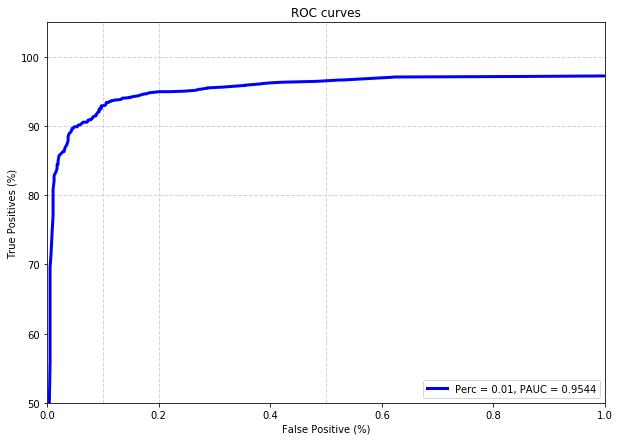

Index(['host_avg_av_labels', 'host_avg_trusted_labels',
       'server_ip_malware_ratio', 'server_ip_suspicious_ratio',
       'server_ip_benign_ratio', 'server_ip_avg_av_labels',
       'server_ip_avg_trusted_labels', 'server_ip_unknown_hash_ratio',
       'bgp_avg_av_labels', 'bgp_avg_trusted_labels',
       'hash_daily_dump_rate_per_client', 'url_struct_malware_downloads',
       'url_struct_total_downloads', 'url_struct_distinct_sha1s'],
      dtype='object')
Train: instances = 36379   features = 58
Test:  instances = 58247   features = 58


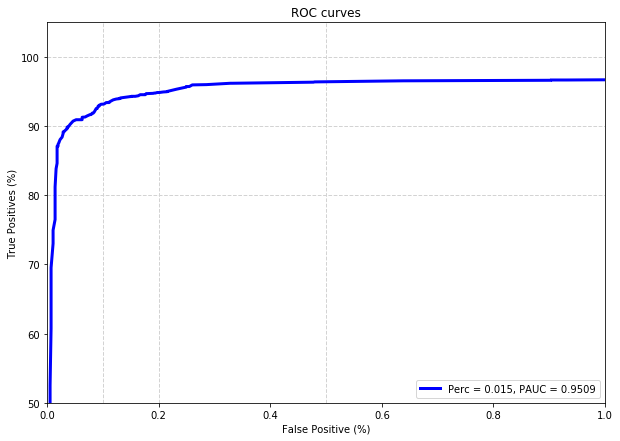

Index(['host_avg_av_labels', 'host_avg_trusted_labels',
       'server_ip_malware_ratio', 'server_ip_suspicious_ratio',
       'server_ip_benign_ratio', 'server_ip_avg_av_labels',
       'server_ip_avg_trusted_labels', 'server_ip_unknown_hash_ratio',
       'hash_daily_dump_rate_per_client', 'url_struct_malware_downloads',
       'url_struct_total_downloads', 'url_struct_distinct_sha1s'],
      dtype='object')
Train: instances = 36379   features = 60
Test:  instances = 58247   features = 60


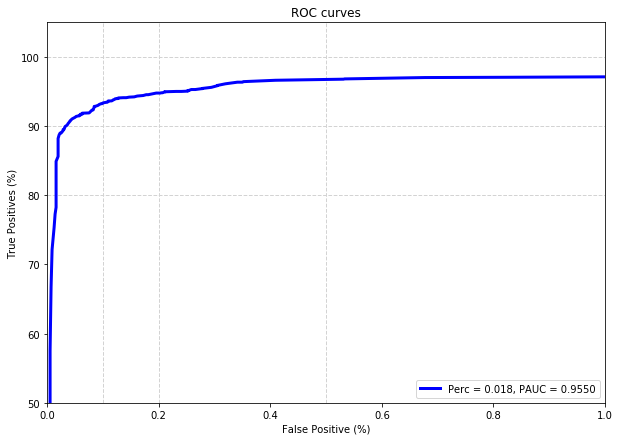

Index(['server_ip_malware_ratio', 'server_ip_suspicious_ratio',
       'server_ip_benign_ratio', 'server_ip_avg_av_labels',
       'server_ip_avg_trusted_labels', 'server_ip_unknown_hash_ratio',
       'hash_daily_dump_rate_per_client', 'url_struct_malware_downloads',
       'url_struct_total_downloads', 'url_struct_distinct_sha1s'],
      dtype='object')
Train: instances = 36379   features = 62
Test:  instances = 58247   features = 62


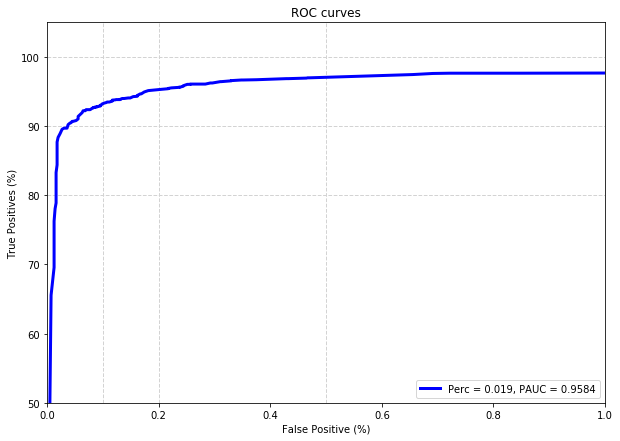

Index(['server_ip_malware_ratio', 'server_ip_suspicious_ratio',
       'server_ip_benign_ratio', 'server_ip_avg_av_labels',
       'server_ip_avg_trusted_labels', 'server_ip_unknown_hash_ratio',
       'hash_daily_dump_rate_per_client', 'url_struct_malware_downloads',
       'url_struct_total_downloads', 'url_struct_distinct_sha1s'],
      dtype='object')
Train: instances = 36379   features = 62
Test:  instances = 58247   features = 62


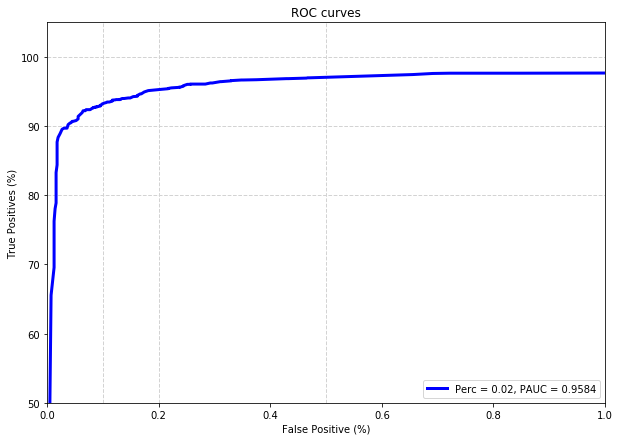

Index(['hash_daily_dump_rate_per_client', 'url_struct_malware_downloads',
       'url_struct_total_downloads', 'url_struct_distinct_sha1s'],
      dtype='object')
Train: instances = 36379   features = 68
Test:  instances = 58247   features = 68


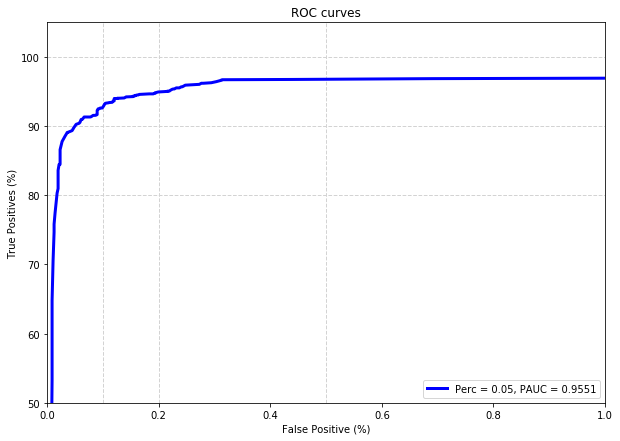

Index(['url_struct_malware_downloads', 'url_struct_total_downloads',
       'url_struct_distinct_sha1s'],
      dtype='object')
Train: instances = 36379   features = 69
Test:  instances = 58247   features = 69


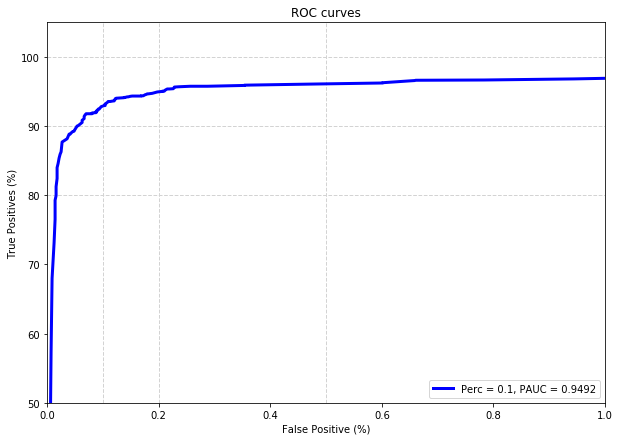

Index(['url_struct_malware_downloads', 'url_struct_total_downloads',
       'url_struct_distinct_sha1s'],
      dtype='object')
Train: instances = 36379   features = 69
Test:  instances = 58247   features = 69


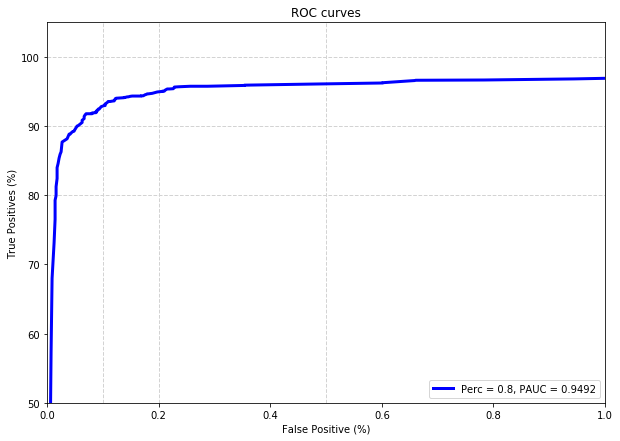

Index([], dtype='object')
Train: instances = 36379   features = 72
Test:  instances = 58247   features = 72


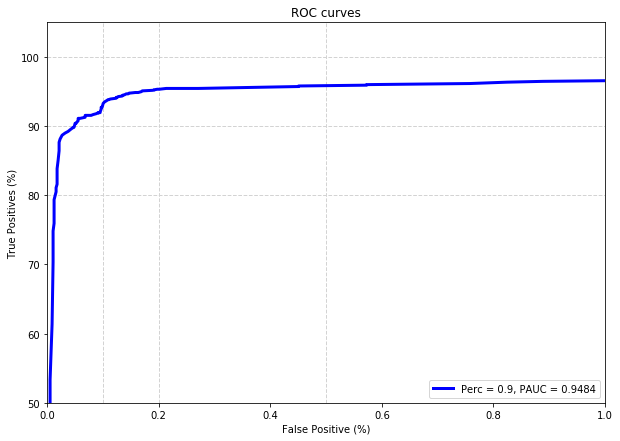

In [22]:
miss_perc = [0.01, 0.015, 0.018, 0.019, 0.02, 0.05, 0.1, 0.8, 0.9]

#print(train.isnull().mean())
temp_cols = list()
#all_cols = list(train.columns[0:])
#print (all_cols)

tmp_train = train.copy()
tmp_test = test.copy()
i = 0

label = list(map(str, miss_perc))
#colours = {'0.01':'blue','0.02':'red','0.04':'darkorange','0.05':'darkgreen','0.06':'navy','0.1':'maroon','0.8':'purple','0.9':'brown'}


for x in miss_perc:
    temp_cols = (train.columns[train.isnull().mean() >= x])
    
    
    for c in temp_cols:
        del tmp_train[c]
        del tmp_test[c]
    
    
    print(temp_cols)
    print ("Train: instances =",tmp_train.shape[0], "  features =",tmp_train.shape[1])
    print ("Test:  instances =",tmp_test.shape[0], "  features =",tmp_test.shape[1]) 
    
    tmp_train = tmp_train.fillna(-1)
    tmp_test = tmp_test.fillna(-1)
    
    fpr1, tpr1 = RF_2(tmp_train, tmp_test)
    
    plot_ROC(fpr1, tpr1, x)
    
    tmp_train = train.copy()
    tmp_test = test.copy()
    i = i+1
    
    #print('Columns for %.2f' % x)
    #print(len(temp_cols), temp_cols)

#for x in miss_perc:
#    print("Fpr %i"%x, fpr1[x])
#    print("Tpr %i"%x, tpr1[x])



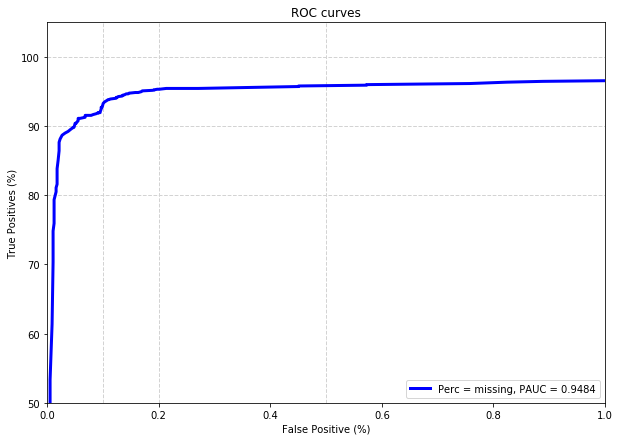

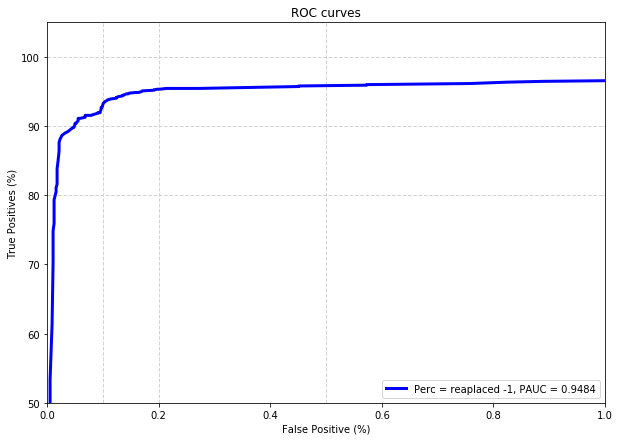

In [23]:
tmp_train = train.copy()
tmp_test = test.copy()


fpr1, tpr1 = RF_2(tmp_train, tmp_test)
    
plot_ROC(fpr1, tpr1, 'missing')

print("\n\n")

tmp_train = tmp_train.fillna(-1)
tmp_test = tmp_test.fillna(-1)


fpr1, tpr1 = RF_2(tmp_train, tmp_test)
    
plot_ROC(fpr1, tpr1, 'reaplaced -1')